# Assignment 1

In this assignment, you will explore a dataset. 

You can choose a dataset to follow this assignment from the list of available datasets in https://pytorch.org/vision/stable/datasets.html . Given that you will be asked to extract RGB descriptros, you should select 3-channel images.

Comment your code and indicate what the different instructions are doing and what you are showing and printing. 
When printing figures do not forget about the title, x and y labels. The font size should be matching the text size of the text in your report. 
Do not forget to add legends to the plots. 

In [1]:
# Load needed packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import random
from skimage import img_as_float
from skimage.color import gray2rgb
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Exercise: Load data

Load the dataset. 
Print how many samples, classes, and shape of an image. 

In [2]:
import torchvision

dataset = torchvision.datasets.CIFAR10("./datasets", download=True)

Files already downloaded and verified


In [3]:
print(dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./datasets
    Split: Train


In [4]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F7A9A8E01C0>, 6)

### What does the CIFAR10 dataset look like ?

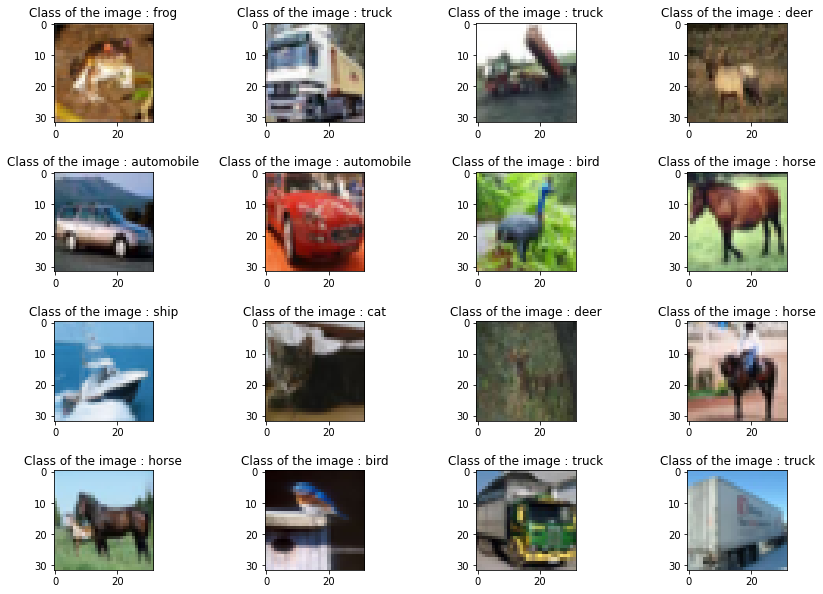

In [6]:
fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i][j].imshow(dataset[4*i+j][0])
        axs[i][j].set_title("Class of the image : {}".format(dataset.classes[dataset[4*i+j][1]]))

plt.subplots_adjust(bottom=0.1, 
                    right=2, 
                    top=2, 
                    wspace=0.2, 
                    hspace=0.5)
plt.show()

### Exercise: Quantify dataset

1) Print the number of samples per category.

2) Plot these number using a bar plot.

Reflection: Are you working with a balanced dataset? unbalanced dataset? Are there majoritarian classes? Do you think this will affect the later analysis and training of your models?

In [7]:
classes = [[] for i in range(10)]
for (i,c) in dataset:
    classes[c].append(i)
count_classes = [len(classes[c]) for c in range(10)]

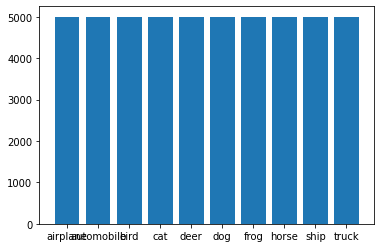

[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


In [8]:
plt.bar([dataset.classes[c] for c in range(10)],count_classes)
plt.show()
print(count_classes)

In [9]:
count_classes_ratio = 1/len(dataset)*np.array(count_classes)
for c in range(10):
    print("Number of samples for class {}, representing {:.0f}% of the total dataset.".format(dataset.classes[c],100*count_classes_ratio[c]))

Number of samples for class airplane, representing 10% of the total dataset.
Number of samples for class automobile, representing 10% of the total dataset.
Number of samples for class bird, representing 10% of the total dataset.
Number of samples for class cat, representing 10% of the total dataset.
Number of samples for class deer, representing 10% of the total dataset.
Number of samples for class dog, representing 10% of the total dataset.
Number of samples for class frog, representing 10% of the total dataset.
Number of samples for class horse, representing 10% of the total dataset.
Number of samples for class ship, representing 10% of the total dataset.
Number of samples for class truck, representing 10% of the total dataset.


### It seems that the CIFAR10 dataset is balanced.

### Exercise: Visualize images

Create a figure with n x 4 images, one per category of your dataset. The value of n will depend on the number of categories of your selected dataset.
As the title of each of the images in your figure, indicate the category it belongs to.

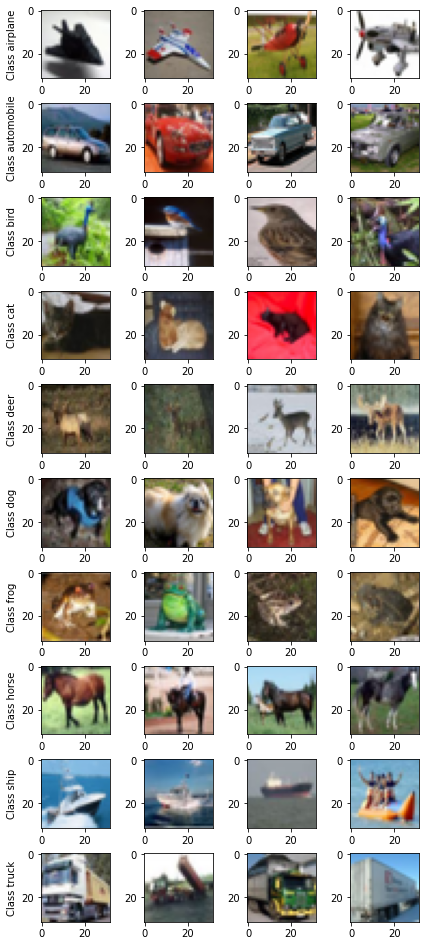

In [10]:
n_classes = 10
n_samples = 4

fig, axs = plt.subplots(n_classes, n_samples)
for i in range(n_classes):
    plt.setp(axs[i][0], ylabel='Class {}'.format(dataset.classes[i]))
    for j in range(n_samples):
        axs[i][j].imshow(classes[i][j])

plt.subplots_adjust(bottom=1.8, 
                    right=1, 
                    top=5, 
                    wspace=0.5)
plt.show()

### Exercise: RGB feature extraction

Extract RGB values from the image as three lists. 8 values per channel. To do so, you can compute the histogram of each channel with 8 bits, and then concatenate those values. The resulting descriptor will have 24 values (8 values per channel). This feature vector is the descriptor of an images in your dataset.

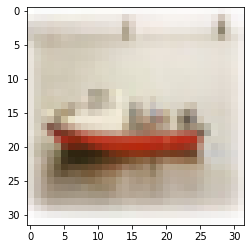

In [11]:
c = np.random.randint(9)
r = np.random.randint(len(classes[c]))
image = classes[c][r]
plt.imshow(image)
plt.show()

In [12]:
img = np.array(image)

r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

print(r.shape)

(32, 32)


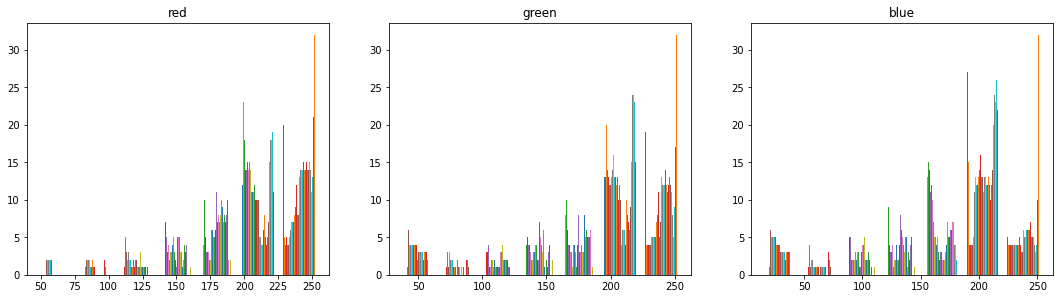

In [13]:
fig, axs = plt.subplots(1,3)

axs[0].hist(r,bins=7)
axs[0].set_title("red")
axs[1].hist(g,bins=7)
axs[1].set_title("green")
axs[2].hist(b,bins=7)
axs[2].set_title("blue")

plt.subplots_adjust(top=1, right=2.5,wspace=0.2)

plt.show()

In [14]:
r_bins = np.array(np.histogram(r,7)[1])
g_bins = np.array(np.histogram(g,7)[1])
b_bins = np.array(np.histogram(b,7)[1])

descriptor = np.array(list(r_bins)+list(g_bins)+list(b_bins))
print(descriptor)

[ 47.          76.71428571 106.42857143 136.14285714 165.85714286
 195.57142857 225.28571429 255.          35.          66.42857143
  97.85714286 129.28571429 160.71428571 192.14285714 223.57142857
 255.          13.          47.57142857  82.14285714 116.71428571
 151.28571429 185.85714286 220.42857143 255.        ]


In [15]:
def make_descriptor(img):
    img = np.array(img)
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    r_bins = np.array(np.histogram(r,7)[1])
    g_bins = np.array(np.histogram(g,7)[1])
    b_bins = np.array(np.histogram(b,7)[1])
    return(list(r_bins)+list(g_bins)+list(b_bins))

### Exercise: Correlation among samples of the different categories

After extracting the RGB descriptors, you have now descriptors and labels (each category represents a label). 

Compute the inter-class and intra-class variability of your dataset. 

Hints:

- For intra-class correlation you can use the implementation from the pingouin package,
https://pingouin-stats.org/generated/pingouin.intraclass_corr.html

- For inter-class correlation you can compute the variability among the descriptors of the samples that belong to a category.

In [25]:
targets = []
raters = []
ratings = []

for (img, label) in dataset:
    descriptor = make_descriptor(img)
    for i in range(len(descriptor)):
        targets.append(i)
        raters.append(label)
        ratings.append(descriptor[i])

In [26]:
dict = {"Targets": targets, "Raters": raters, "Ratings": ratings}

In [31]:
df = pd.DataFrame(data=dict)
df

,Targets,Raters,Ratings
0,0,6,0.000000
1,1,6,36.428571
2,2,6,72.857143
3,3,6,109.285714
4,4,6,145.714286
...,...,...,...
1199995,19,1,112.714286
1199996,20,1,148.285714
1199997,21,1,183.857143
1199998,22,1,219.428571


In [29]:
icc = pg.intraclass_corr(data=df, targets="Targets", raters="Raters", ratings="Ratings").round(3)
icc.set_index("Type")

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.991,1104.714,23,216,0.0,"[0.98, 1.0]"
ICC2,Single random raters,0.991,1645.506,23,207,0.0,"[0.98, 1.0]"
ICC3,Single fixed raters,0.994,1645.506,23,207,0.0,"[0.99, 1.0]"
ICC1k,Average raters absolute,0.999,1104.714,23,216,0.0,"[1.0, 1.0]"
ICC2k,Average random raters,0.999,1645.506,23,207,0.0,"[1.0, 1.0]"
ICC3k,Average fixed raters,0.999,1645.506,23,207,0.0,"[1.0, 1.0]"


The Silhouette score is used to assess the performance of using unsupervised machine learning (clustering). We can also use it here to assess the compactness of the extracted descriptors.

You can use the function available in Sklearn;

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [43]:
descriptors = [[] for i in range(len(classes))]
for (img, label) in dataset:
    descriptors[label].append(make_descriptor(img))

In [49]:
stds = [np.std(descriptors[i]) for i in range(len(classes))]
means = [np.average(descriptors[i]) for i in range(len(classes))]
print(stds)
print(means)

[72.075874002879, 77.7565130346638, 69.31978585329034, 73.58723322904615, 67.55539056156596, 73.64150517758958, 69.67905149252489, 74.1737318005623, 73.11207894656593, 77.71524210299408]
[128.23356666666666, 125.48473333333334, 122.19433333333333, 123.80786666666667, 119.1494, 124.8266, 116.28023333333333, 127.08756666666666, 128.56766666666667, 127.65633333333334]


In [62]:
desc, labels = [], []

for img, label in dataset:
    desc.append(make_descriptor(img))
    labels.append(label)

In [76]:
df2 = {}
values = [[] for i in range(len(desc[0]))]
for i in range(len(dataset)):
    for k in range(len(desc[0])):
        values[k].append(desc[i][k])
for k in range(len(desc[0])):
    df2["D"+str(k)] = values[k]
df2["Label"] = labels

In [77]:
df2 = pd.DataFrame(df2)
df2

,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D15,D16,D17,D18,D19,D20,D21,D22,D23,Label
0,0.0,36.428571,72.857143,109.285714,145.714286,182.142857,218.571429,255.0,0.0,36.142857,...,253.0,0.0,33.571429,67.142857,100.714286,134.285714,167.857143,201.428571,235.0,6
1,5.0,40.571429,76.142857,111.714286,147.285714,182.857143,218.428571,254.0,6.0,41.285714,...,253.0,7.0,42.285714,77.571429,112.857143,148.142857,183.428571,218.714286,254.0,9
2,23.0,56.142857,89.285714,122.428571,155.571429,188.714286,221.857143,255.0,20.0,53.571429,...,255.0,21.0,54.428571,87.857143,121.285714,154.714286,188.142857,221.571429,255.0,9
3,16.0,47.142857,78.285714,109.428571,140.571429,171.714286,202.857143,234.0,13.0,40.571429,...,206.0,4.0,27.428571,50.857143,74.285714,97.714286,121.142857,144.571429,168.0,4
4,0.0,36.285714,72.571429,108.857143,145.142857,181.428571,217.714286,254.0,0.0,35.428571,...,248.0,0.0,35.428571,70.857143,106.285714,141.714286,177.142857,212.571429,248.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,28.0,52.000000,76.000000,100.000000,124.000000,148.000000,172.000000,196.0,34.0,59.571429,...,213.0,49.0,76.714286,104.428571,132.142857,159.857143,187.571429,215.285714,243.0,2
49996,53.0,81.857143,110.714286,139.571429,168.428571,197.285714,226.142857,255.0,21.0,53.857143,...,251.0,13.0,30.857143,48.714286,66.571429,84.428571,102.285714,120.142857,138.0,6
49997,0.0,35.857143,71.714286,107.571429,143.428571,179.285714,215.142857,251.0,7.0,42.142857,...,253.0,6.0,41.571429,77.142857,112.714286,148.285714,183.857143,219.428571,255.0,9
49998,0.0,35.714286,71.428571,107.142857,142.857143,178.571429,214.285714,250.0,0.0,35.714286,...,250.0,0.0,36.428571,72.857143,109.285714,145.714286,182.142857,218.571429,255.0,1


In [87]:
y = df2["Label"]
X = df2.drop(["Label"], axis=1)
X

,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23
0,0.0,36.428571,72.857143,109.285714,145.714286,182.142857,218.571429,255.0,0.0,36.142857,...,216.857143,253.0,0.0,33.571429,67.142857,100.714286,134.285714,167.857143,201.428571,235.0
1,5.0,40.571429,76.142857,111.714286,147.285714,182.857143,218.428571,254.0,6.0,41.285714,...,217.714286,253.0,7.0,42.285714,77.571429,112.857143,148.142857,183.428571,218.714286,254.0
2,23.0,56.142857,89.285714,122.428571,155.571429,188.714286,221.857143,255.0,20.0,53.571429,...,221.428571,255.0,21.0,54.428571,87.857143,121.285714,154.714286,188.142857,221.571429,255.0
3,16.0,47.142857,78.285714,109.428571,140.571429,171.714286,202.857143,234.0,13.0,40.571429,...,178.428571,206.0,4.0,27.428571,50.857143,74.285714,97.714286,121.142857,144.571429,168.0
4,0.0,36.285714,72.571429,108.857143,145.142857,181.428571,217.714286,254.0,0.0,35.428571,...,212.571429,248.0,0.0,35.428571,70.857143,106.285714,141.714286,177.142857,212.571429,248.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,28.0,52.000000,76.000000,100.000000,124.000000,148.000000,172.000000,196.0,34.0,59.571429,...,187.428571,213.0,49.0,76.714286,104.428571,132.142857,159.857143,187.571429,215.285714,243.0
49996,53.0,81.857143,110.714286,139.571429,168.428571,197.285714,226.142857,255.0,21.0,53.857143,...,218.142857,251.0,13.0,30.857143,48.714286,66.571429,84.428571,102.285714,120.142857,138.0
49997,0.0,35.857143,71.714286,107.571429,143.428571,179.285714,215.142857,251.0,7.0,42.142857,...,217.857143,253.0,6.0,41.571429,77.142857,112.714286,148.285714,183.857143,219.428571,255.0
49998,0.0,35.714286,71.428571,107.142857,142.857143,178.571429,214.285714,250.0,0.0,35.714286,...,214.285714,250.0,0.0,36.428571,72.857143,109.285714,145.714286,182.142857,218.571429,255.0


In [88]:
silhouette_score(X,y)

-0.16260237138116376

Reflection: Do these metrics help you assess the degree of similarity among the samples of a category? what about among categories? What can you deduce?

### Exercise: Dimensionality reduction for visualization 

We can visualize 2- or 3-dimensional spaces. 
For this reason, you need to reduce dimensionality. 

In this exercise you are asked to use PCA for reducing dimensionality.

Link to function to apply PCA: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Create the following two figures:

1) Rely on the first 2 principal components to plot the samples of your dataset. 

2) Rely on the first 3 principal components to create a 3D plot.


In [221]:
pca2 = PCA(n_components=2)
principalComponents = pca2.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
finalDf = pd.concat([principalDf, df[['Class']]], axis = 1)
finalDf

,PC1,PC2,Class
0,-16.310208,-45.048317,6
1,-47.629356,-37.922079,9
2,-75.044777,-0.046110,9
3,105.561157,11.052116,4
4,-26.310374,-49.648466,1
...,...,...,...
49995,-5.982973,36.020027,2
49996,58.677309,69.807357,6
49997,-44.357965,-43.222197,9
49998,-33.463392,-52.763653,1


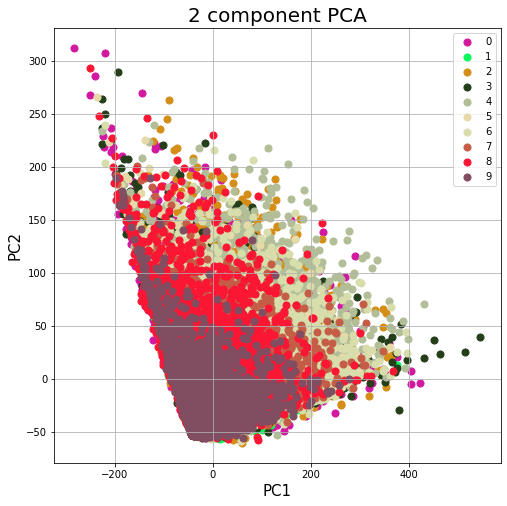

In [246]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [i for i in range(10)]
colors = [(random.random(), random.random(), random.random()) for i in range(10)]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , color = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [243]:
pca3 = PCA(n_components=3)
principalComponents2 = pca3.fit_transform(X)
principalDf2 = pd.DataFrame(data = principalComponents2, columns = ['PC1', 'PC2', 'PC3'])
finalDf2 = pd.concat([principalDf2, df[['Class']]], axis = 1)
finalDf2

,PC1,PC2,PC3,Class
0,-16.310208,-45.048317,-25.845611,6
1,-47.629356,-37.922079,-3.183462,9
2,-75.044777,-0.046110,-3.115634,9
3,105.561157,11.052116,-53.479280,4
4,-26.310374,-49.648466,-10.004275,1
...,...,...,...,...
49995,-5.982973,36.020027,93.672333,2
49996,58.677309,69.807357,-140.281382,6
49997,-44.357965,-43.222197,3.572430,9
49998,-33.463392,-52.763653,0.872504,1


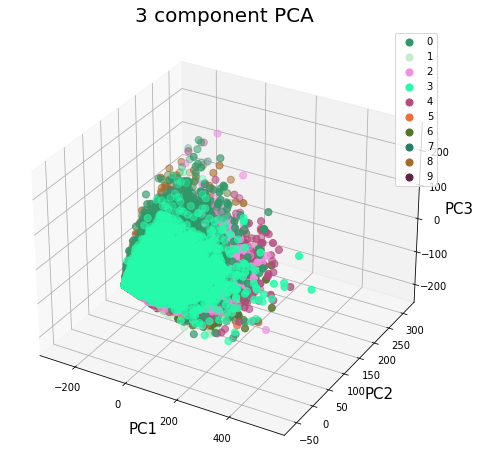

In [256]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_zlabel('PC3', fontsize = 15)

ax.set_title('3 component PCA', fontsize = 20)
targets = [i for i in range(10)]
colors = [(random.random(), random.random(), random.random()) for i in range(10)]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf2['Class'] == target
    ax.scatter(finalDf2.loc[indicesToKeep, 'PC1']
               , finalDf2.loc[indicesToKeep, 'PC2']
               , finalDf2.loc[indicesToKeep, 'PC3']
               , color = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Exercise: Reflection

Reflect on the following questions. Your answers can be implemented in the report for the practical.

    - Will you obtain the same visualisation in the feature space for diffrent extracted features?
    
    - Are the classes distinguishable on the feature space when relaying on PCA over RGB?
    
    - What other visualization could you include to better describe your data?

In [12]:
# your reflection here

### [Optional] Exercise: Repeat experiments with different image descriptros

e.g. 
- Harris Corner Detection

- Shi-Tomasi Corner Detector and Good Features to Track

- Scale-Invariant Feature Transform (SIFT)

- Speeded-up robust features (SURF)

- Features from Accelerated Segment Test (FAST)

- Blob Detectors With LoG, DoG, and DoH

If you have OpenCV installed you can follow this examples,
https://automaticaddison.com/image-feature-detection-description-and-matching-in-opencv/

When using Scikit-image,
https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=hog